# MNISTを学習させて作成したモデルの評価

## 1. データ前処理

In [3]:
from datasets import load_dataset
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

# モデルとProcessorの準備
model = AutoModelForImageClassification.from_pretrained("../mnist-vit/checkpoint-5625").to("cuda").eval()
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# データセットのロード
dataset = load_dataset("mnist", split="test")

# transformとデータ前処理
transform = Compose([
    Resize((224, 224)),
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

def preprocess(example):
    image = transform(example["image"])
    example["pixel_values"] = image
    return example

dataset = dataset.map(preprocess)
dataset.set_format(type="torch", columns=["pixel_values", "label"])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## 2. バッチで推論して精度を測る

In [4]:
from torch.utils.data import DataLoader
from tqdm import tqdm

dataloader = DataLoader(dataset, batch_size=64)

correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(dataloader):
        inputs = batch["pixel_values"].to("cuda")
        labels = batch["label"].to("cuda")
        outputs = model(pixel_values=inputs)
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total

print(f"Test Accuracy: {accuracy}")

100%|██████████| 157/157 [01:45<00:00,  1.49it/s]

Test Accuracy: 0.9965


## 3. 混同行列を作成する

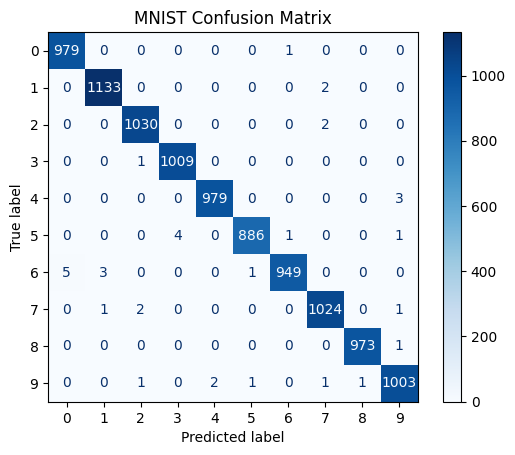

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:
        inputs = batch["pixel_values"].to("cuda")
        labels = batch["label"].to("cuda")
        outputs = model(pixel_values=inputs)
        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap="Blues")
plt.title("MNIST Confusion Matrix")
plt.show()

## 4. F1-score を算出

以下のように算出できます

$$
\text{F1} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In [6]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9949    0.9990    0.9969       980
           1     0.9965    0.9982    0.9974      1135
           2     0.9961    0.9981    0.9971      1032
           3     0.9961    0.9990    0.9975      1010
           4     0.9980    0.9969    0.9975       982
           5     0.9977    0.9933    0.9955       892
           6     0.9979    0.9906    0.9942       958
           7     0.9951    0.9961    0.9956      1028
           8     0.9990    0.9990    0.9990       974
           9     0.9941    0.9941    0.9941      1009

    accuracy                         0.9965     10000
   macro avg     0.9965    0.9964    0.9965     10000
weighted avg     0.9965    0.9965    0.9965     10000

